In [2]:
import osmnx as ox
import networkx as nx
import ast
import sys
import json
# Change this for your local machine
# sys.path.append("C:\\Users\\gabri\\Documents\\CMOR492-DWS")
sys.path.append("D:\\Users\\gabri\\Documents\\Distributed Water System Modeling Spring 2025\\CMOR492-DWS")
from network_construction.network import get_Utown, source_treatment

D:\Users\gabri\Documents\Distributed Water System Modeling Spring 2025\CMOR492-DWS\network_construction\network.py:12: SyntaxWarning: invalid escape sequence '\m'
  config.read('C:\\Users\mbans\Desktop\CMOR492-DWS\DWS\config.ini')


In [12]:
G0 = ox.load_graphml("road_net_2.graphml")

MultiDiGraph with 199 nodes and 506 edges


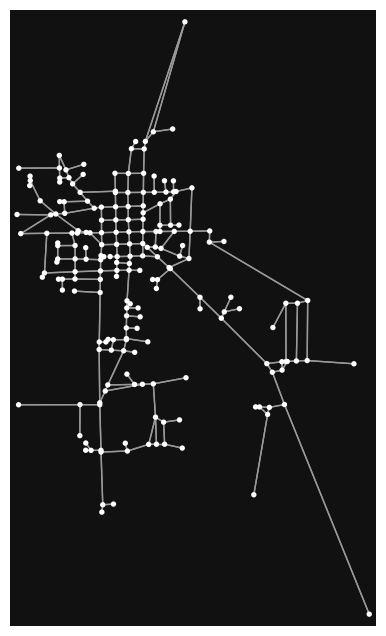

Duplicate edge 5
Duplicate edge 10
Duplicate edge 14
Duplicate edge 16
Duplicate edge 21
Duplicate edge 23
Duplicate edge 30
Duplicate edge 32
Duplicate edge 40
Duplicate edge 46
Duplicate edge 55
Duplicate edge 58
Duplicate edge 60
Duplicate edge 63
Duplicate edge 64
Duplicate edge 65
Duplicate edge 69
Duplicate edge 71
Duplicate edge 75
Duplicate edge 76
Duplicate edge 78
Duplicate edge 80
Duplicate edge 82
Duplicate edge 85
Duplicate edge 88
Duplicate edge 92
Duplicate edge 93
Duplicate edge 94
Duplicate edge 96
Duplicate edge 97
Duplicate edge 100
Duplicate edge 104
Duplicate edge 107
Duplicate edge 110
Duplicate edge 112
Duplicate edge 113
Duplicate edge 114
Duplicate edge 117
Duplicate edge 121
Duplicate edge 125
Duplicate edge 126
Duplicate edge 130
Duplicate edge 133
Duplicate edge 134
Duplicate edge 139
Duplicate edge 140
Duplicate edge 141
Duplicate edge 144
Duplicate edge 147
Duplicate edge 149
Duplicate edge 152
Duplicate edge 158
Duplicate edge 159
Duplicate edge 161
Dupli

In [22]:

print(G0)
ox.plot_graph(G0)
edge_set = set()
for count, (u,v,key) in enumerate(G0.edges(keys=True)):
    if ((u,v) in edge_set) or ((v,u) in edge_set):
        print(f"Duplicate edge {count}")
    else:
        edge_set.add((u,v))

In [14]:
print(G0.edges())

[(59079200, 59103180), (59079983, 59079984), (59079983, 59112334), (59079983, 59106124), (59079984, 59125609), (59079984, 59079983), (59079984, 59125613), (59080764, 59080765), (59080764, 59082984), (59080764, 59084990), (59080765, 59080764), (59080765, 59080775), (59080765, 59095026), (59080775, 59080788), (59080775, 59080765), (59080775, 59107322), (59080788, 59080775), (59080788, 59123873), (59080788, 59095026), (59081555, 59081564), (59081564, 59081566), (59081564, 59081555), (59081564, 59095700), (59081566, 59081564), (59081566, 59112364), (59081566, 59112347), (59081605, 59096556), (59081605, 59081615), (59081605, 59123873), (59081615, 59081625), (59081615, 59081605), (59081615, 59102119), (59081625, 59081615), (59081682, 59084990), (59081682, 59084971), (59081682, 59104191), (59081782, 59081790), (59081782, 59112364), (59081782, 59146293), (59081790, 9930802707), (59081790, 59081782), (59081790, 9930785225), (59081840, 59081845), (59081840, 59123827), (59081840, 59101042), (5908

# Why we're getting a `crs` attribute error
It's because we're copying some but not all attributes of the OSMnx multidigraph to a fresh digraph.

OSMnx gives us a directional multigraph from the .graphml file, with multiple edges between nodes representing different directions of travel along the same path. However, we don't care which direction the roads go in. The cell directly below copies some attributes of the multidigraph into a new digraph.

However, OSMnx provides internal methods for converting the original multidigraph to a graph, which is all we need.

In [6]:
print(G0.graph)

{'created_date': '2025-01-23 19:48:42', 'created_with': 'OSMnx 1.9.4', 'crs': 'epsg:4326', 'simplified': True}


In [29]:
def remove_duplicate_edges(graph_with_duplicates, print_exclusions=False):
    """ 
    Returns a new, plottable, networkx MultiDiGraph with duplicate edges removed.
    I.e., if for nodes u and v there are multiple edges (u,v) or (v,u) in the 
    original graph, the new graph only has one such edge.

    Also adds the "crs" attribute to the new graph so the new graph can be plotted
    in OSMnx

    Paramters
    ---------
    graph_with_duplicates : networkx.MultiDiGraph
    
    print_exclusions : boolean, default False
    If set to True, prints out the nodes of an edge whenever excluded
    
    Returns
    -------
    graph_new : networkx.MultiDiGraph
    """
    graph_new = nx.MultiDiGraph()

    # Copy nodes and their attributes
    graph_new.add_nodes_from(graph_with_duplicates.nodes(data=True))

    # Iterate through edges and, if they're not duplicates, add them to the new graph
    included_edges = set()
    for u, v, edge_key, data in graph_with_duplicates.edges(keys=True, data=True):
        if (u,v) not in included_edges and (v,u) not in included_edges:
            graph_new.add_edge(u,v,edge_key,**data)
            included_edges.add((u,v))
        elif print_exclusions: 
            print(f"Duplicate edge {(u,v)} excluded")
        
    graph_new.graph["crs"] = G0.graph["crs"]
    
    return graph_new


In [30]:
G = remove_duplicate_edges(G0, print_exclusions=True)

Duplicate edge (59079984, 59079983) excluded
Duplicate edge (59080765, 59080764) excluded
Duplicate edge (59080775, 59080765) excluded
Duplicate edge (59080788, 59080775) excluded
Duplicate edge (59081564, 59081555) excluded
Duplicate edge (59081566, 59081564) excluded
Duplicate edge (59081615, 59081605) excluded
Duplicate edge (59081625, 59081615) excluded
Duplicate edge (59081790, 59081782) excluded
Duplicate edge (59081845, 59081840) excluded
Duplicate edge (59082984, 59080764) excluded
Duplicate edge (59084971, 59081682) excluded
Duplicate edge (59084975, 59084971) excluded
Duplicate edge (59084990, 59084975) excluded
Duplicate edge (59084990, 59080764) excluded
Duplicate edge (59084990, 59081682) excluded
Duplicate edge (59091076, 59091067) excluded
Duplicate edge (59091084, 59091076) excluded
Duplicate edge (59095026, 59080765) excluded
Duplicate edge (59095026, 59080788) excluded
Duplicate edge (59095700, 59081564) excluded
Duplicate edge (59095757, 59081840) excluded
Duplicate 

In [ ]:

source_nodes, treatment_nodes = source_treatment(G)

ValueError: min() iterable argument is empty

In [ ]:
G0.graph["crs"]
G.graph["crs"]

'epsg:4326'

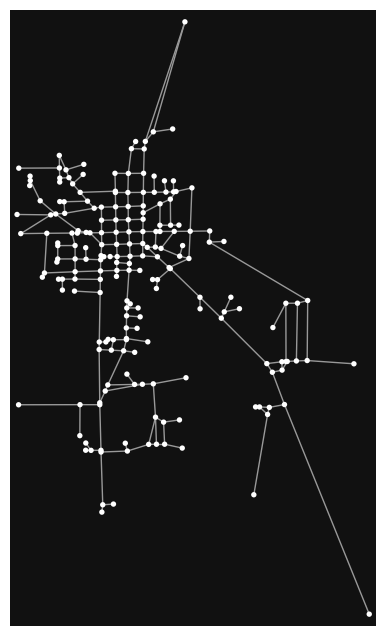

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [31]:
ox.plot_graph(G)

In [34]:
with open("solutions\\y_sol_period_0.json", "r") as f:
    y_sol_0 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

with open("solutions\\z_sol_period_0.json", "r") as f:
    z_sol_0 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

with open("solutions\\y_sol_period_1.json", "r") as f:
    y_sol_1 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

with open("solutions\\z_sol_period_1.json", "r") as f:
    z_sol_1 = {ast.literal_eval(key): value for key, value in json.load(f).items()}

In [41]:
def plot_pipe_network(graph, treatment_nodes, source_nodes, selected_treatment_centers, selected_edges):
    node_colors = []
    for node in graph.nodes:
        if node in treatment_nodes:
            if selected_treatment_centers[node] == 1:
                node_colors.append("yellow") # Node is a treatment node and is selected by model
            else:
                node_colors.append("gray") # Node is a treatment node but was not selected
        elif node in source_nodes:
            node_colors.append("#336699")
        else: # Uh-oh! All nodes should be either a treatment node or a source node.
            node_colors.append("magenta")

    edge_colors = ['white' if selected_edges[*e] == 1 else "#101010" for e in graph.edges(data=False)]

    # node_colors = ['r' if node in treatment_nodes else '#336699' for node in G.nodes()]

    node_sizes = [50 if node in treatment_nodes else 15 for node in graph.nodes]

    ox.plot_graph(G, node_color=node_colors, node_size=node_sizes, edge_color=edge_colors, edge_linewidth=1, bgcolor="#000000")

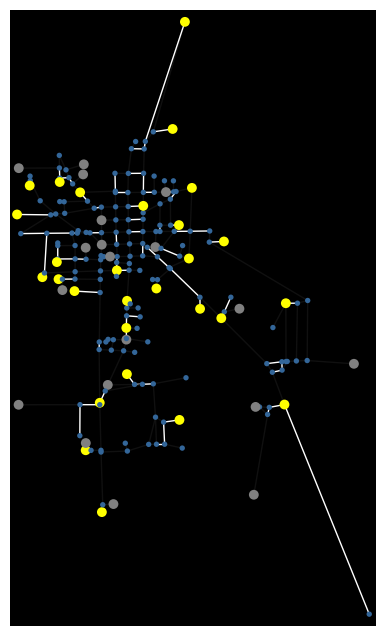

In [42]:
plot_pipe_network(G, treatment_nodes, source_nodes, y_sol_0, z_sol_0)

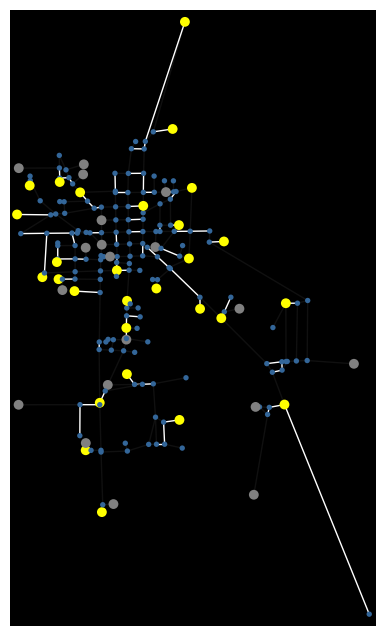

In [43]:
plot_pipe_network(G, treatment_nodes, source_nodes, y_sol_1, z_sol_1)

KeyError: 'crs'

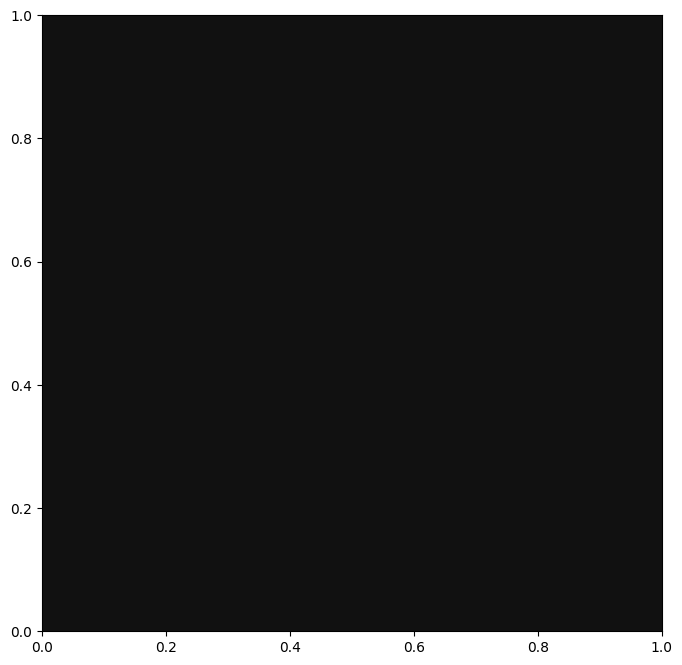

In [37]:
G_directed_graph = ox.convert.to_digraph(G0)
G_to_plot = nx.MultiDiGraph()
G_to_plot.add_nodes_from(G_directed_graph.nodes)
G_to_plot.add_edges_from(G_directed_graph.edges.data())
ox.plot_graph(G_to_plot)

In [36]:
G_directed_graph.graph["crs"]

'epsg:4326'

TypeError: OutEdgeView.__call__() got an unexpected keyword argument 'keys'

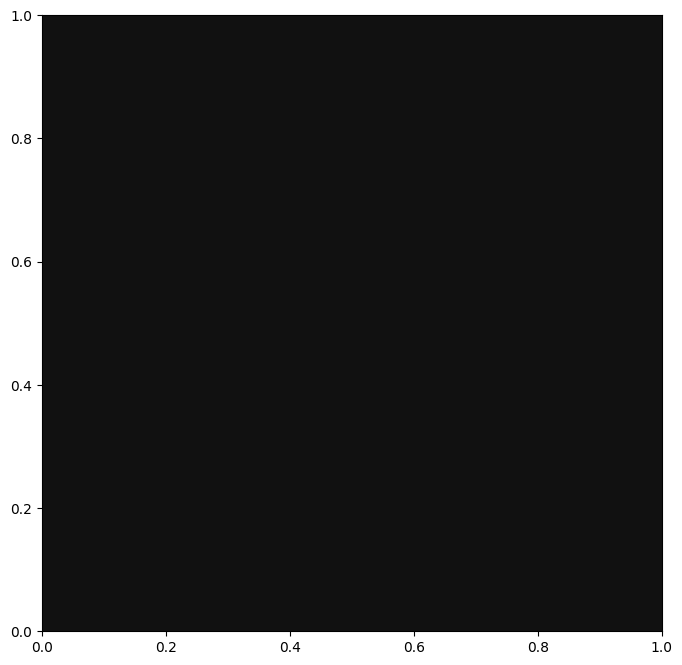

In [35]:
ox.plot_graph(G_directed_graph)

In [ ]:
G_proj = ox.project_graph(G)

KeyError: 'crs'

In [ ]:
G_proj.graph["crs"]

KeyError: 'crs'

In [ ]:
print(y_sol_1)
print(G.graph)
print(z_sol_1)

{59128065: 1.0, 59133314: 1.0, 59116291: 0.0, 59121412: 0.0, 59081605: 0.0, 59126150: 1.0, 59133192: 1.0, 59117577: 0.0, 59091084: 1.0, 59123853: 1.0, 59110286: 1.0, 59116300: 0.0, 59129101: 0.0, 59146899: 1.0, 59095700: 0.0, 59124248: 0.0, 59096602: 0.0, 59110431: 0.0, 59079200: 1.0, 3584201894: 0.0, 4231830135: 1.0, 59123881: 1.0, 59101100: 0.0, 59079983: 0.0, 59090484: 1.0, 59146293: 1.0, 59129525: 1.0, 59118652: 1.0, 59103172: 0.0, 59101385: 1.0, 59146313: 0.0, 59110347: 0.0, 59158864: 1.0, 59133777: 1.0, 59146231: 1.0, 59080788: 0.0, 59081566: 1.0, 9941438054: 1.0, 59147494: 1.0, 59124459: 1.0, 59115372: 1.0, 59153773: 1.0, 4230838774: 1.0, 59164150: 0.0, 59113465: 0.0, 59107322: 1.0, 59097341: 1.0}
{'crs': 'epsg:4326'}
{(59079200, 59103180): 0.0, (59079983, 59079984): 0.0, (59079983, 59112334): 0.0, (59079983, 59106124): 0.0, (59079984, 59125609): 1.0, (59079984, 59079983): 0.0, (59079984, 59125613): 0.0, (59080764, 59080765): 1.0, (59080764, 59082984): 0.0, (59080764, 59084990):

In [ ]:
print(G.edges(data=False))

[(59079200, 59103180), (59079983, 59079984), (59079983, 59112334), (59079983, 59106124), (59079984, 59125609), (59079984, 59079983), (59079984, 59125613), (59080764, 59080765), (59080764, 59082984), (59080764, 59084990), (59080765, 59080764), (59080765, 59080775), (59080765, 59095026), (59080775, 59080788), (59080775, 59080765), (59080775, 59107322), (59080788, 59080775), (59080788, 59123873), (59080788, 59095026), (59081555, 59081564), (59081564, 59081566), (59081564, 59081555), (59081564, 59095700), (59081566, 59081564), (59081566, 59112364), (59081566, 59112347), (59081605, 59096556), (59081605, 59081615), (59081605, 59123873), (59081615, 59081625), (59081615, 59081605), (59081615, 59102119), (59081625, 59081615), (59081682, 59084990), (59081682, 59084971), (59081682, 59104191), (59081782, 59081790), (59081782, 59112364), (59081782, 59146293), (59081790, 9930802707), (59081790, 59081782), (59081790, 9930785225), (59081840, 59081845), (59081840, 59123827), (59081840, 59101042), (5908

In [12]:
print(z_sol_1[59079200, 59103180])

0.0


In [ ]:
G.graph["crs"]

KeyError: 'crs'

In [3]:
y_sol

{59128065: 1.0,
 59133314: 1.0,
 59116291: 0.0,
 59121412: 0.0,
 59081605: 0.0,
 59126150: 1.0,
 59133192: 1.0,
 59117577: 0.0,
 59091084: 1.0,
 59123853: 1.0,
 59110286: 1.0,
 59116300: 0.0,
 59129101: 0.0,
 59146899: 1.0,
 59095700: 0.0,
 59124248: 0.0,
 59096602: 0.0,
 59110431: 0.0,
 59079200: 1.0,
 3584201894: 0.0,
 4231830135: 1.0,
 59123881: 1.0,
 59101100: 0.0,
 59079983: 0.0,
 59090484: 1.0,
 59146293: 1.0,
 59129525: 1.0,
 59118652: 1.0,
 59103172: 0.0,
 59101385: 1.0,
 59146313: 0.0,
 59110347: 0.0,
 59158864: 1.0,
 59133777: 1.0,
 59146231: 1.0,
 59080788: 0.0,
 59081566: 1.0,
 9941438054: 1.0,
 59147494: 1.0,
 59124459: 1.0,
 59115372: 1.0,
 59153773: 1.0,
 4230838774: 1.0,
 59164150: 0.0,
 59113465: 0.0,
 59107322: 1.0,
 59097341: 1.0}